# Task 05 - Non-parametric probability density estimation - Parzen window
## Pattern Recognition and Machine Learning

In [1]:
%load_ext autoreload
%autoreload 2
# uncomment following for interactive matplotlib
# %matplotlib notebook

from parzen import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.optimize as opt
import copy
from PIL import Image

In [8]:
# [0.22639369336698353, 0.17268427772080927, 0.076097169]
p = my_parzen(np.array([1, 2, 3]), np.array([-1, 0, 2, 1.5, 0]), 1.0)
print(p)

[0.22639369 0.17268428 0.07609717]


## Load data

In [2]:
data = np.load("data_33rpz_parzen.npz", allow_pickle=True)
tst = data["tst"].item()
trn = data["trn"].item()

## Tasks, part 1
#### measurements

In [10]:
x = compute_measurement_lr_cont(trn['images'])

# splitting the trainning data into classes
idxs = np.squeeze(trn['labels'])
xA = x[idxs == 0]
xC = x[idxs == 1]

#### computing the histograms of training data

In [11]:
hist_A, bins_A = np.histogram(xA, 20, density=True)
hist_C, bins_C = np.histogram(xC, 20, density=True)

#### estimating conditional probability using Parzen window

In [10]:
proverka = norm.pdf(x_range[0], xA, 100.)

In [12]:
x_range = np.arange(np.min(xA), np.max(xA), 100)
h = [100., 500., 1000., 2000.]

y = np.zeros([len(h), x_range.size], np.float64)
for i in range(len(h)):
    y[i,:] = my_parzen(x_range, xA, h[i])

#### visualisation

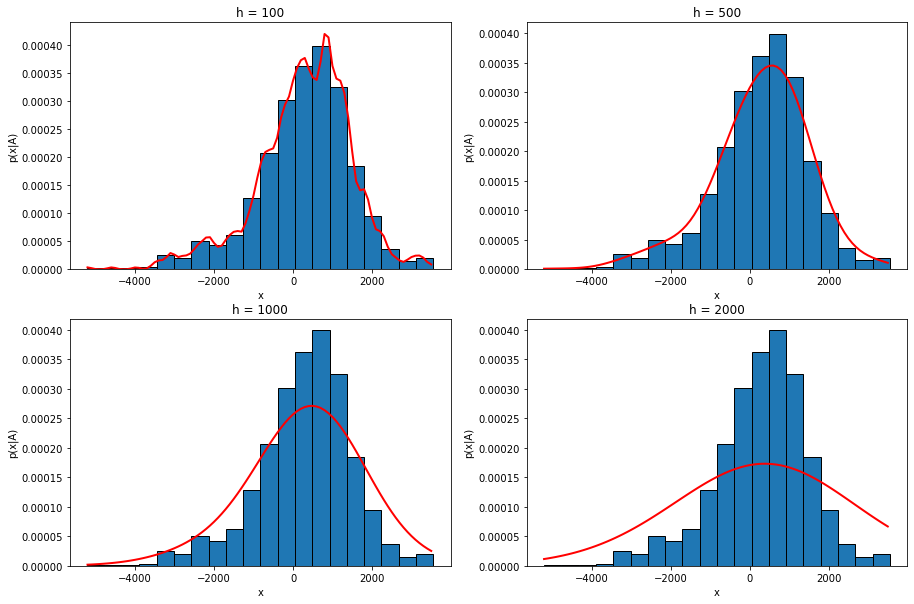

In [13]:
def plot_parzen(x, y, hist, bins, h=500., cls='A'):
    centers = (bins[:-1] + bins[1:]) / 2
    width = bins[:-1] - bins[1:]
    plt.bar(centers, hist, width=width, edgecolor='k')
    plt.plot(x.T, y.T, 'r', linewidth=2)
    plt.title('h = {:.0f}'.format(h))
    plt.xlabel('x')
    plt.ylabel('p(x|{})'.format(cls))

# plots of the estimates
plt.figure(figsize=(15,10))

for idx in range(4):
    cur_h = h[idx]
    plt.subplot(2,2,idx+1)
    plot_parzen(x_range, y[idx:(idx+1),:], hist_A, bins_A, h=cur_h)

plt.savefig('parzen_estimates.png')

#### interactive visualisation
This is an optional feature. You do not need this for the assignment fulfil.
In the case that you are intereted, install **ipywidgets** and you can play with **the slider**.

In [60]:
try:
    from ipywidgets import interact, interactive, fixed
    
    @interact(h=(10.,2000.,10.))
    def plot_parzen_interactive(h=500.):
        plt.figure(figsize=(15,10))
        x_range = np.arange(np.min(xA), np.max(xA), 100)
        y = my_parzen(x_range, xA, h)
        plot_parzen(x_range, y, hist_A, bins_A, h=h)
        plt.ylim([0, 4.5e-4])

except ImportError:
    print('Optional feature.')


interactive(children=(FloatSlider(value=500.0, description='h', max=2000.0, min=10.0, step=10.0), Output()), _…

## Tasks, part 2
#### 10-fold cross-validation init

In [7]:
# h_range = np.arange(100,1000+1e-8,50)
h_range = np.linspace(100,1000,19)
num_folds = 10;

#### class A cross-validation

In [8]:
np.random.seed(42)   # to get the same example outputs

num_data = xA.size
itrn, itst = crossval(num_data, num_folds)

# raise NotImplementedError("You have to implement the rest.")
Lh = np.array([])
for cur_h in h_range:
    Lh = np.append(Lh, compute_Lh(itrn, itst, xA, cur_h))

#### optimal value of parameter h

In [9]:
# raise NotImplementedError("You have to implement the rest.")
h_bestA = opt.fminbound(lambda hh: -1 * compute_Lh(itrn, itst, xA, hh), 100, 1000)
Lh_bestA = compute_Lh(itrn, itst, xA, h_bestA)

#### plots of optimal h

NameError: name 'x_range' is not defined

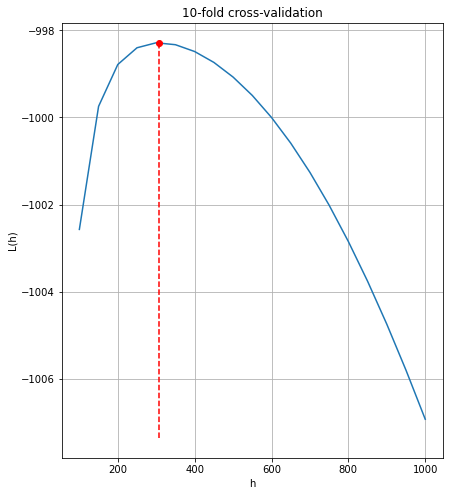

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(h_range, Lh)
plt.plot(h_bestA, Lh_bestA, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestA, h_bestA], [bottom, Lh_bestA], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

y = my_parzen(x_range, xA, h_bestA)
plt.subplot(1,2,2)
plot_parzen(x_range, y, hist_A, bins_A, h=h_bestA)
plt.title('Best bandwidth h for class A')
plt.savefig('optimal_h_classA.png')

#### class C cross-validation

In [14]:
x_range = np.arange(np.min(xC),np.max(xC),100)

np.random.seed(42)   # to get the same example outputs

num_data = xC.size
itrn, itst = crossval(num_data, num_folds)

Lh = np.zeros([h_range.size])
for h_iter in range(h_range.size):
    Lh[h_iter] = compute_Lh(itrn, itst, xC, float(h_range[h_iter]))

#### optimal value of parameter h

In [15]:
h_bestC = opt.fminbound(lambda hh: -compute_Lh(itrn, itst, xC, hh), h_range[0], h_range[-1])
Lh_bestC = compute_Lh(itrn, itst, xC, h_bestC)

#### plots of optimal h

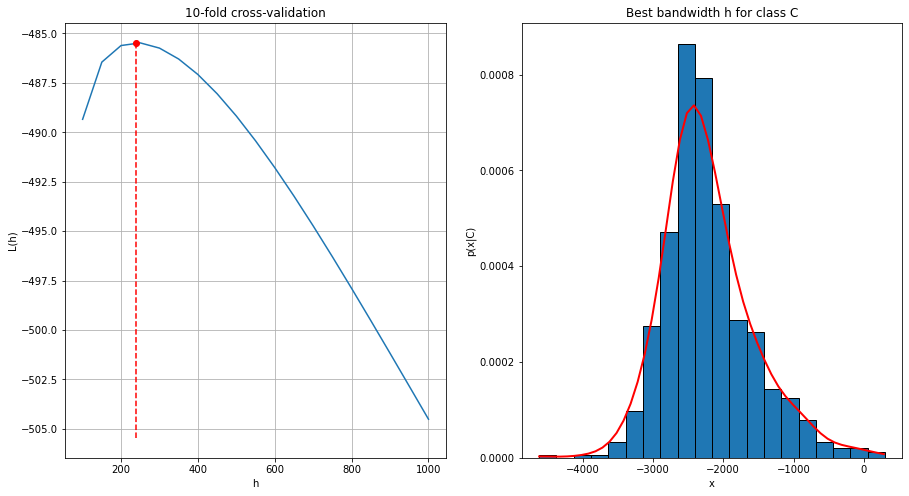

In [63]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(h_range, Lh)
plt.plot(h_bestC, Lh_bestC, 'or')
bottom, _ = plt.ylim()
plt.plot([h_bestC, h_bestC], [bottom, Lh_bestC], '--r');
plt.title('10-fold cross-validation')
plt.xlabel('h')
plt.ylabel('L(h)')
plt.grid('on')

y = my_parzen(x_range, xC, h_bestC)
plt.subplot(1,2,2)
plot_parzen(x_range, y, hist_C, bins_C, h=h_bestC, cls='C')
plt.title('Best bandwidth h for class C')
plt.savefig('optimal_h_classC.png')

## Bayesian classifier

In [64]:
x_test = compute_measurement_lr_cont(tst['images'])

# computing a priori probabilities
n_xA = np.size(xA)
n_xC = np.size(xC)
pA = n_xA/(n_xA + n_xC)
pC = n_xC/(n_xA + n_xC)
labels = classify_bayes_parzen(x_test, xA, xC, pA, pC, h_bestA, h_bestC)

#### visualisation

0.075
7.5


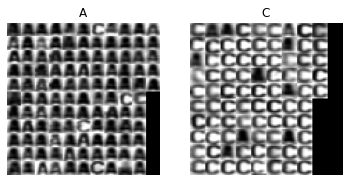

In [67]:
show_classification(tst['images'], labels, 'AC')
plt.savefig('parzen_classif.png')

# classification error
bayes_error = float(np.sum(labels != tst['labels']) / np.size(labels))
print(bayes_error)
print(bayes_error*100)

In [16]:
print(round(h_bestA, 2), round(h_bestC, 2))

307.92 238.68
